In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch
from collections import OrderedDict, defaultdict
import seaborn as sns
import numpy as np
from aux_functions import *

In [278]:
pd.read_parquet('data/results_sravni_tink.parquet')

,text,pred,pred_text,time,rating,old_text,category
6601,Представитель принёс мне домой эту карту и ска...,[],[],2013-10-22T23:09:52.84Z,0,Представитель принёс мне домой эту карту и ска...,creditCards
6600,Здравствуйте ! Я не знаю о каких невежливых со...,"[([8], [7], 'NEG')]","[('сотрудниках', 'невежливых', 'NEG')]",2013-10-23T16:20:55.617Z,5,Здравствуйте! Я не знаю о каких невежливых сот...,creditCards
3476,В кратчайшие сроки со мой связался представите...,"[([2], [1], 'POS')]","[('сроки', 'кратчайшие', 'POS')]",2013-10-23T18:46:31.25Z,5,В кратчайшие сроки со мой связался представите...,serviceLevel
3475,такое впечатление а вернее так и есть что в эт...,[],[],2013-10-24T00:36:17.887Z,1,такое впечатление а вернее так и есть что в эт...,serviceLevel
6599,Сотрудники банка очень доступно объяснили мне ...,"[([153], [154], 'NEG'), ([149], [148], 'NEG')]","[('Банк', 'плохой', 'NEG'), ('ситуации', 'нега...",2013-10-29T10:49:25.113Z,5,Сотрудники банка очень доступно объяснили мне ...,creditCards
...,...,...,...,...,...,...,...
6704,"Решил я как то тут сделать дебетовую карту , н...",[],[],2023-11-14T06:06:00.060509Z,1,"Решил я как то тут сделать дебетовую карту, н...",debitCards
30,"Сегодня случайно оформила подписку "" премиум ""...",[],[],2023-11-14T20:59:11.837788Z,5,"Сегодня случайно оформила подписку ""премиум"", ...",serviceLevel
6703,Поддержка Премиум в Тинькофф банке отличная . ...,"[([0], [5], 'POS'), ([29], [28], 'POS')]","[('Поддержка', 'отличная', 'POS'), ('бонус', '...",2023-11-15T12:34:11.65793Z,5,Поддержка Премиум в Тинькофф банке отличная. С...,debitCards
29,Премиум поддержка в Тинькофф остается на высот...,[],[],2023-11-15T15:20:05.034002Z,5,Премиум поддержка в Тинькофф остается на высот...,serviceLevel


In [277]:
df = pd.read_parquet('data/results_sravni_tink.parquet')
df.sort_values(by=['time']).iloc[:-200].to_parquet('data/results_sravni_tink.parquet')

In [280]:
import pickle

with open('data/constants/max_dates.pickle', 'rb') as f:
    max_dates = pickle.load(f)
    
max_dates['alpha']

{'creditCards': '2024-04-05T13:19:13.861533Z',
 'credits': '2024-01-17T16:56:46.196688Z',
 'debitCards': '2024-04-21T14:05:11.326159Z',
 'mortgage': '2023-12-09T17:53:09.42784Z',
 'other': '2024-02-23T15:06:01.762523Z',
 'remoteService': '2024-04-23T09:47:00.006509Z',
 'savings': '2024-03-23T09:00:42.385947Z',
 'serviceLevel': '2024-04-19T07:48:18.476662Z'}

In [258]:
bank = 'sber'

df = pd.read_parquet(f'data/results_sravni_{bank}.parquet')
df['category'] = df['category'].map(map_category)

In [264]:
all_triplets = []
all_times = []
for _, (label, time) in df[['pred_text', 'time']].iterrows():
    # all_triplets.extend(eval(label))
    label = eval(label)
    all_triplets.extend(label)
    all_times += [time] * len(label)

data = []
for (triplet, time) in zip(all_triplets, all_times):
    # st.write(triplet)
    # st.write(triplet)
    at, ot, sp = triplet
    at = lemmatize(at.lower())
    ot = lemmatize(ot.lower())

    data.append([at, ot, sp, (at, ot, sp), (at, ot), time])
data = pd.DataFrame(data)
data.columns = ['aspect', 'opinion', 'sentiment', 'triplet', 'aspect_opinion', 'timestamp']
data = data[~data.aspect.apply(is_stop_word)]

In [265]:
data['aspect'].value_counts()

aspect
сотрудник       397
отношение       217
обслуживание    199
работа           92
специалист       85
               ... 
диван             1
сообщение         1
выражение         1
слоган            1
статус            1
Name: count, Length: 449, dtype: int64

In [250]:
df[df['pred_text'].apply(lambda x: 'приложение' in x)]

,text,pred,pred_text,time,rating,old_text,category
10,"Условия отличные , удобное приложение , быстро...","[([0], [1], 'POS'), ([4], [3], 'POS'), ([11], ...","[('Условия', 'отличные', 'POS'), ('приложение'...",2023-07-11T07:34:06.935021Z,5,"Условия отличные, удобное приложение, быстрое ...",Кредиты наличными
13,# Кредит \ _наличными \ _в \ _Тинькофф . Тиньк...,"[([22], [21], 'POS'), ([22], [20, 21], 'POS')]","[('приложение', 'удобное', 'POS'), ('приложени...",2023-06-15T18:10:55.015842Z,5,#Кредит\_наличными\_в\_Тинькофф. Тинькофф выбр...,Кредиты наличными
66,"Грустно писать этот отзыв , до последнего не х...","[([75], [74], 'NEG'), ([57], [56], 'NEG'), ([3...","[('приложение', 'слабое', 'NEG'), ('поддержка'...",2022-02-22T09:25:03.901387Z,1,"Грустно писать этот отзыв, до последнего не хо...",Обслуживание
866,Уже месяц пытаюсь дозвониться и дописаться до ...,"[([44], [43], 'NEG'), ([44], [40, 41], 'NEG'),...","[('приложение', 'нелогичное', 'NEG'), ('прилож...",2021-10-07T12:47:06.508546Z,1,Уже месяц пытаюсь дозвониться и дописаться до ...,Ипотека
1334,За 4 года обслуживания в банке накопилось мног...,"[([449], [452, 453], 'NEG'), ([449], [453], 'N...","[('приложение', 'ужасно неудобно', 'NEG'), ('п...",2017-11-01T12:48:34.313Z,1,За 4 года обслуживания в банке накопилось мног...,Кредиты наличными
2122,Всем доброго времени суток ! Дебетовая карта В...,"[([34], [37], 'POS')]","[('приложение', 'удобное', 'POS')]",2023-10-24T11:46:28.735315Z,5,Всем доброго времени суток! Дебетовая карта ВТ...,Дебетовые карты
2125,Больше 3 - х лет являюсь клиентом банка ВТБ . ...,"[([11], [13], 'POS'), ([11], [10], 'POS'), ([2...","[('банк', 'удобное', 'POS'), ('банк', 'Хороший...",2023-10-18T07:02:54.571232Z,5,Больше 3- х лет являюсь клиентом банка ВТБ. Хо...,Дебетовые карты
2126,"Удобные тарифы и приложение , но минус из - за...","[([1], [0], 'POS'), ([81], [80], 'NEG'), ([3],...","[('тарифы', 'Удобные', 'POS'), ('операций', 'с...",2023-10-16T14:17:41.735073Z,4,"Удобные тарифы и приложение, но минус из-за ко...",Дебетовые карты
2271,Всем привет . Особенно банку ВТБ24 . ​ Очередн...,"[([318], [317], 'POS'), ([315], [314], 'POS'),...","[('сервисом', 'адекватным', 'POS'), ('приложен...",2018-07-07T18:32:57.207Z,3,Всем привет. Особенно банку ВТБ24.\n\n​\n\nОче...,Дебетовые карты


In [118]:
bank = 'Тинькофф'
    
possible_competitors = ['Тинькофф', 'Сбербанк', 'ВТБ', 'Альфа-банк']
possible_competitors.remove(bank)

competitors = possible_competitors




bank = map_bank[bank]
competitors = [map_bank[competitor] for competitor in competitors]

n_competitors = len(competitors)





df = pd.read_parquet(f'data/results_sravni_{bank}.parquet')
df['category'] = df['category'].map(map_category)
df['triplets'] = df['pred_text']
df['timestamp'] = pd.to_datetime(df['time'].apply(lambda x: x[:10]))
df = df[~df['text'].apply(lambda x: 'ЛовиОтзыв' in x)]

count_dates = df['time'].value_counts()
df = df[df['time'].isin(count_dates[count_dates<100].index)]








df_competitors = []
for competitor in competitors:
    df_competitor = pd.read_parquet(f'data/results_sravni_{competitor}.parquet')
    df_competitor['category'] = df_competitor['category'].map(map_category)
    df_competitor['triplets'] = df_competitor['pred_text']
    df_competitor['timestamp'] = pd.to_datetime(df_competitor['time'].apply(lambda x: x[:10]))
    df_competitor = df_competitor[~df_competitor['text'].apply(lambda x: 'ЛовиОтзыв' in x)]

    count_dates = df_competitor['time'].value_counts()
    df_competitor = df_competitor[df_competitor['time'].isin(count_dates[count_dates<100].index)]


    df_competitors.append(df_competitor)
# data['triplet'] = data['pred_text'].apply(lambda x: eval(x))
# all_triplets = []
# for label in data['triplet']:
#     all_triplets.extend(label)
# st.write(data)

all_triplets = []
all_times = []
for _, (label, time) in df[['triplets', 'timestamp']].iterrows():
    # all_triplets.extend(eval(label))
    label = eval(label)
    all_triplets.extend(label)
    all_times += [time] * len(label)

data = []
for (triplet, time) in zip(all_triplets, all_times):
    # st.write(triplet)
    # st.write(triplet)
    at, ot, sp = triplet
    at = lemmatize(at.lower())
    ot = lemmatize(ot.lower())

    data.append([at, ot, sp, (at, ot, sp), (at, ot), time])
data = pd.DataFrame(data)
data.columns = ['aspect', 'opinion', 'sentiment', 'triplet', 'aspect_opinion', 'timestamp']
data = data[~data.aspect.apply(is_stop_word)]

aspect_counts = data['aspect'].value_counts()
correct_aspects = {}
for i, (a, count) in enumerate(aspect_counts.items()):
    if len(a) < 6: continue
    for j in range(i):
        b = aspect_counts.index[j]
        if a[0] == b[0] and a[-1] == b[-1] and lev(a, b) <= 1:
            correct_aspects[a] = b
            break

data['aspect'] = data['aspect'].apply(lambda x : correct_aspects.get(x, x))




all_triplets_competitors = []
all_times_competitors = []
for i in range(n_competitors):
    all_triplets = []
    all_times = []
    for _, (label, time) in df_competitors[i][['triplets', 'timestamp']].iterrows():
        # all_triplets.extend(eval(label))
        label = eval(label)
        all_triplets.extend(label)
        all_times += [time] * len(label)
    all_triplets_competitors.append(all_triplets)
    all_times_competitors.append(all_times)


data_competitors = []
for i in range(n_competitors):
    data_competitor = []
    for (triplet, time) in zip(all_triplets_competitors[i], all_times_competitors[i]):
        at, ot, sp = triplet
        at = lemmatize(at.lower())
        ot = lemmatize(ot.lower())
        data_competitor.append([at, ot, sp, (at, ot, sp), (at, ot), time])




    data_competitor = pd.DataFrame(data_competitor)
    data_competitor.columns = ['aspect', 'opinion', 'sentiment', 'triplet', 'aspect_opinion', 'timestamp']
    data_competitor = data_competitor[~data_competitor.aspect.apply(is_stop_word)]

    aspect_counts = data_competitor['aspect'].value_counts()
    correct_aspects = {}
    for i, (a, count) in enumerate(aspect_counts.items()):
        if len(a) < 6: continue
        for j in range(i):
            b = aspect_counts.index[j]
            if a[0] == b[0] and a[-1] == b[-1] and lev(a, b) <= 1:
                correct_aspects[a] = b
                break

    data_competitor['aspect'] = data_competitor['aspect'].apply(lambda x : correct_aspects.get(x, x))

    data_competitors.append(data_competitor)

In [ ]:
def common_sentiment_bytime(data, bank):
    data_sorted = data.sort_values("timestamp", ascending=True)

    def count_pos_neg(group):
        sent_dict = {"count_pos": 0, "count_neg": 0}
        for item in group:
            if item == "POS":
                sent_dict["count_pos"] += 1
            else:
                sent_dict["count_neg"] += 1
        return sent_dict

    counted_sentiment = (
        data_sorted.groupby("timestamp")[["sentiment"]]
        .agg(count_pos_neg)
        .reset_index(names=["timestamp"])
    )

    count_pos = 1
    count_neg = 1
    ratio = []
    for i, item in counted_sentiment.iterrows():
        count_pos += item["sentiment"]["count_pos"]
        count_neg += item["sentiment"]["count_neg"]
        # ratio.append(count_pos / count_neg )
        ratio.append(100 * count_pos / (count_neg + count_pos))

    smoothing_k = 2
    data_ratio = counted_sentiment[["timestamp"]].iloc[::smoothing_k]
    data_ratio["Доля положительных"] = ratio[::smoothing_k]

    fig = px.line(data_ratio, x="timestamp", y="Доля положительных")
    fig.update_yaxes(range=[min(ratio) - 1, max(ratio) + 1], autorange=False)
    #   fig.get_axes().set_ylim(min(ratio)-1, max(ratio)+1)
    # fig.update_layout(scattermode="group")
    #   fig.yaxis_title('Доля положительных триплетов')
    #   fig.xaxis_title('Дата')
    fig.update_layout(
        # title=f"Доля положительных триплетов по времени",
        title=map_bank_eng_to_rus[bank],
        xaxis_title="Дата",
        yaxis_title="Доля положительных триплетов",
    )
    # fig.show()
    st.plotly_chart(fig)

st.subheader("Доля положительных тональностей с течением времени")


for i in range(n_competitors + 1):
    if i == 0:
        common_sentiment_bytime(data, bank)
    else:
        common_sentiment_bytime(data_competitors[i-1], competitors[i-1])



In [223]:
data
bank = 'tink'

data_sorted = data.sort_values("timestamp", ascending=True)

def count_pos_neg(group):
    sent_dict = {"count_pos": 0, "count_neg": 0}
    for item in group:
        if item == "POS":
            sent_dict["count_pos"] += 1
        else:
            sent_dict["count_neg"] += 1
    return sent_dict

counted_sentiment = (
    data_sorted.groupby("timestamp")[["sentiment"]]
    .agg(count_pos_neg)
    .reset_index(names=["timestamp"])
)

count_pos = 1
count_neg = 1
ratio = []
for i, item in counted_sentiment.iterrows():
    count_pos += item["sentiment"]["count_pos"]
    count_neg += item["sentiment"]["count_neg"]
    # ratio.append(count_pos / count_neg )
    ratio.append(100 * count_pos / (count_neg + count_pos))

smoothing_k = 2
data_ratio = counted_sentiment[["timestamp"]].iloc[::smoothing_k]
data_ratio["Доля положительных"] = ratio[::smoothing_k]
data_ratio['Банк'] = map_bank_reverse[bank]
data_ratio_all = data_ratio.copy()


for i in range(n_competitors):
    data_sorted = data_competitors[i].sort_values("timestamp", ascending=True)
    
    counted_sentiment = (
        data_sorted.groupby("timestamp")[["sentiment"]]
        .agg(count_pos_neg)
        .reset_index(names=["timestamp"])
    )

    count_pos = 1
    count_neg = 1
    ratio = []
    for j, item in counted_sentiment.iterrows():
        count_pos += item["sentiment"]["count_pos"]
        count_neg += item["sentiment"]["count_neg"]
        # ratio.append(count_pos / count_neg )
        ratio.append(100 * count_pos / (count_neg + count_pos))

    smoothing_k = 2
    data_ratio = counted_sentiment[["timestamp"]].iloc[::smoothing_k]
    data_ratio["Доля положительных"] = ratio[::smoothing_k]
    data_ratio['Банк'] = map_bank_reverse[competitors[i]]
    data_ratio_all = pd.concat([data_ratio_all, data_ratio], axis=0)
data_ratio_all

,timestamp,Доля положительных,Банк
0,2013-10-23,50.000000,Тинькофф
2,2013-11-07,50.000000,Тинькофф
4,2013-11-12,70.000000,Тинькофф
6,2013-11-19,81.250000,Тинькофф
8,2013-12-16,72.222222,Тинькофф
...,...,...,...
974,2024-04-15,97.280418,Альфа-банк
976,2024-04-17,97.280601,Альфа-банк
978,2024-04-19,97.278756,Альфа-банк
980,2024-04-21,97.279507,Альфа-банк


In [209]:
colors = {'tink': 'yellow',
          'alpha': 'red',
          'vtb': 'blue',
          'sber': 'green',
         }

In [224]:
map_bank

{'Тинькофф': 'tink', 'Сбербанк': 'sber', 'ВТБ': 'vtb', 'Альфа-банк': 'alpha'}

In [227]:
colors

{'tink': 'yellow', 'alpha': 'red', 'vtb': 'blue', 'sber': 'green'}

/Users/nik/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/Users/nik/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



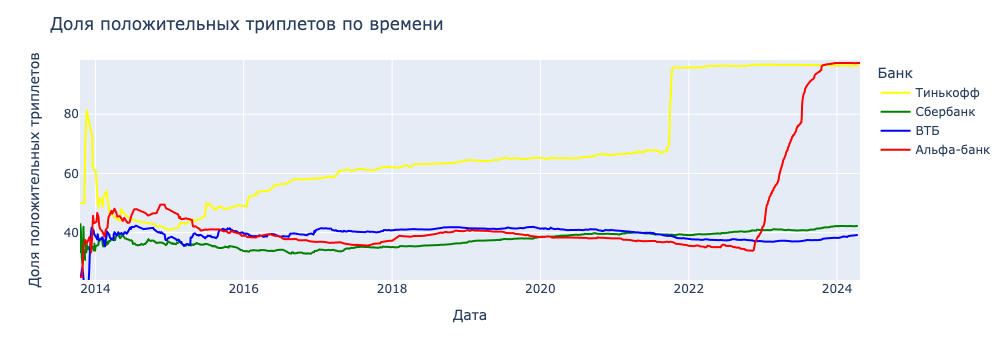

In [228]:
fig = px.line(data_ratio_all, x="timestamp", y="Доля положительных", color='Банк',
             color_discrete_map={map_bank_reverse[bank]:color for bank, color in colors.items()})
fig.update_yaxes(range=[min(ratio) - 1, max(ratio) + 1], autorange=False)


fig.update_layout(
    title=f"Доля положительных триплетов по времени",
    # title=map_bank_eng_to_rus[bank],
    xaxis_title="Дата",
    yaxis_title="Доля положительных триплетов",
)
fig.show()
# st.plotly_chart(fig)

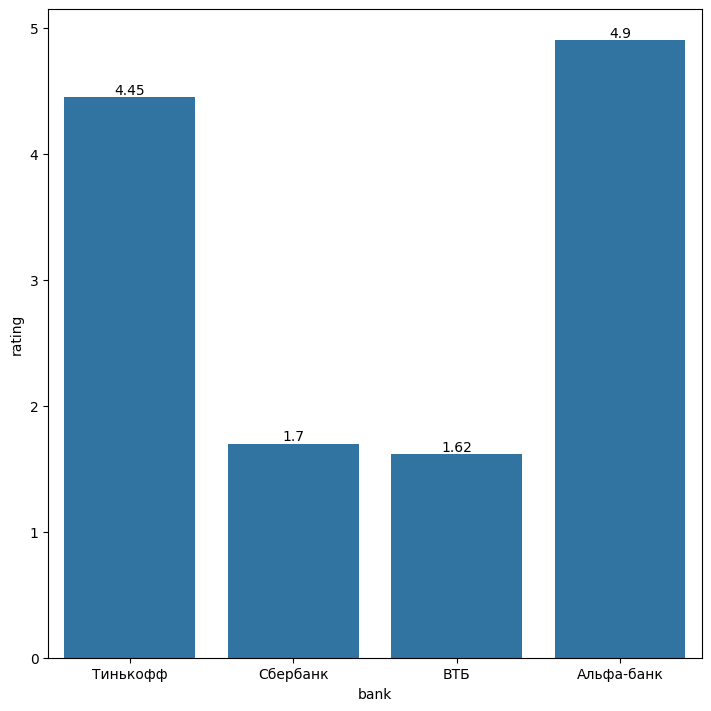

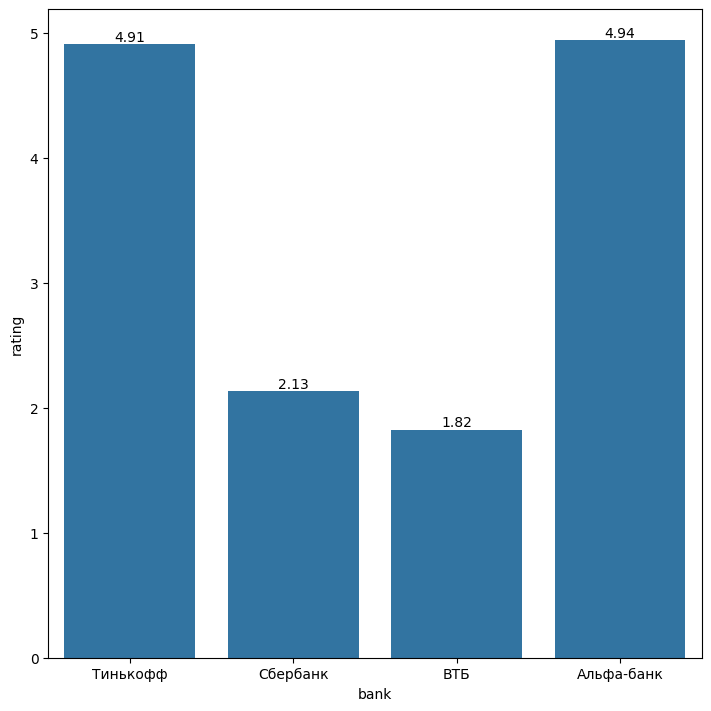

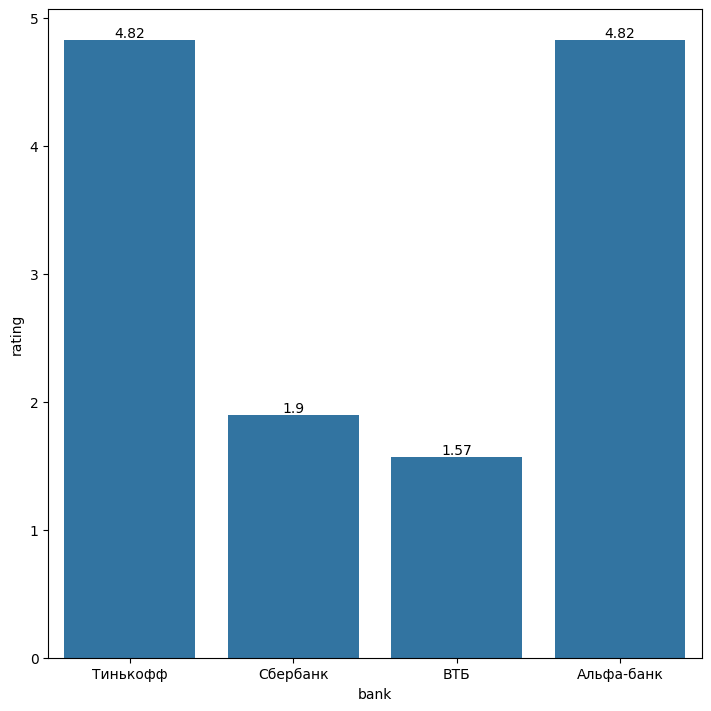

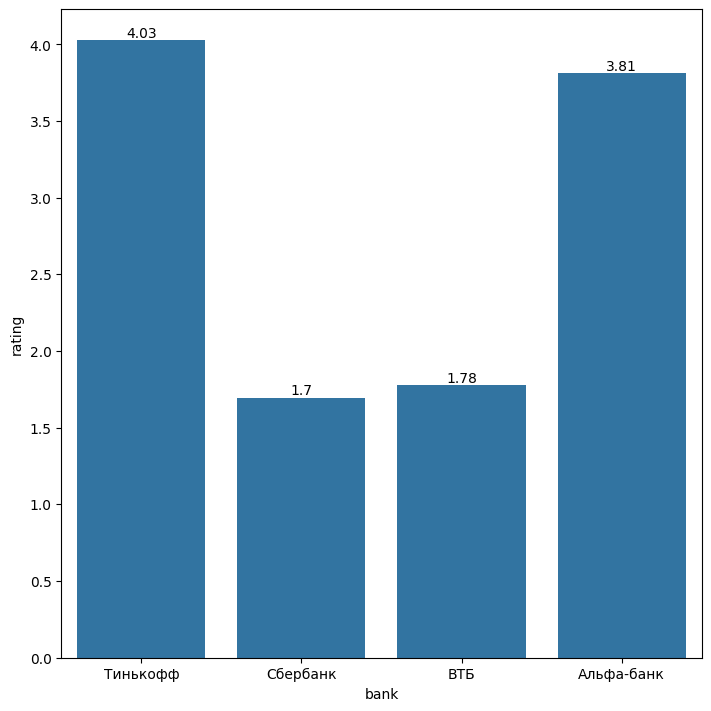

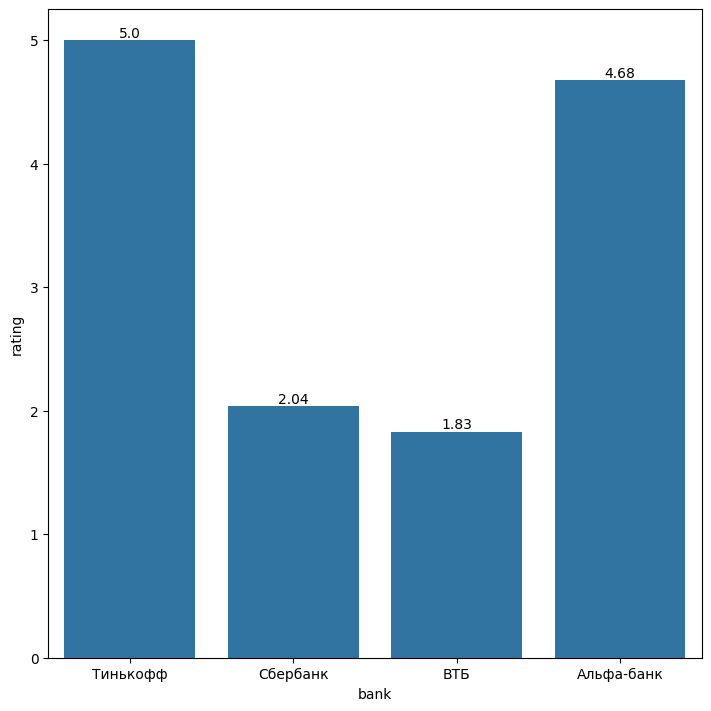

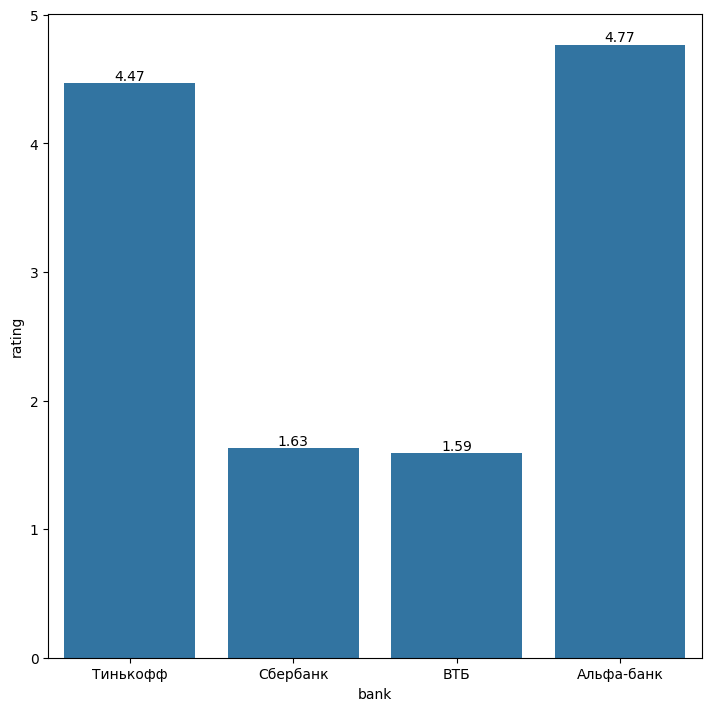

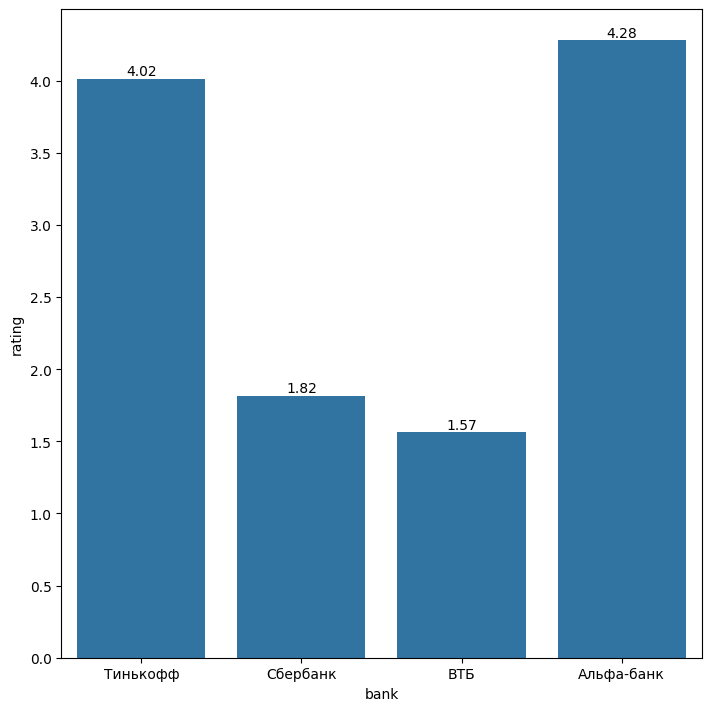

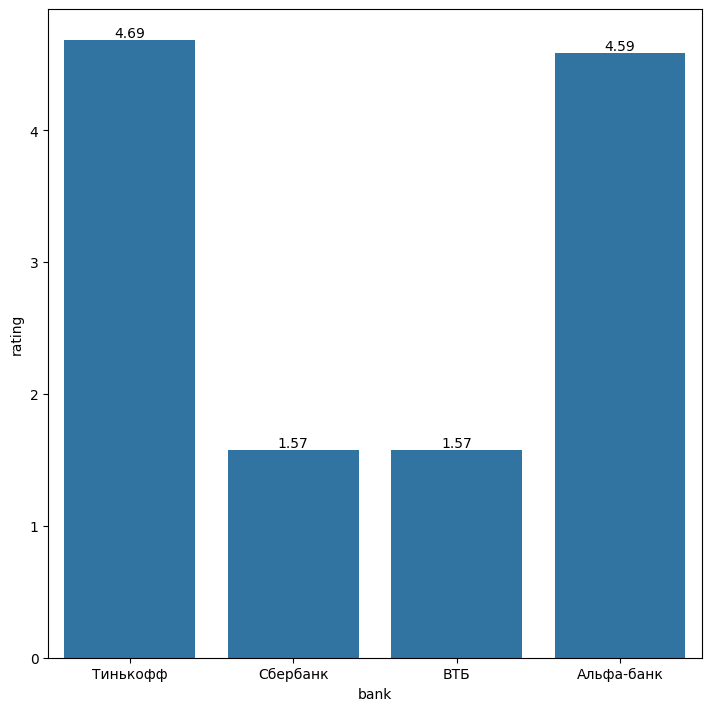

In [172]:
for cat in np.unique(mean_ratings['category']):
    fig, ax = plt.subplots(layout="constrained", figsize=(7, 7))
    sns.barplot(mean_ratings[mean_ratings.category==cat], x='bank', y='rating', ax=ax)
    ax.bar_label(ax.containers[0], fmt=lambda x: str(round(x, 2)), label_type='edge')
    plt.show();

<Axes: xlabel='category', ylabel='rating'>

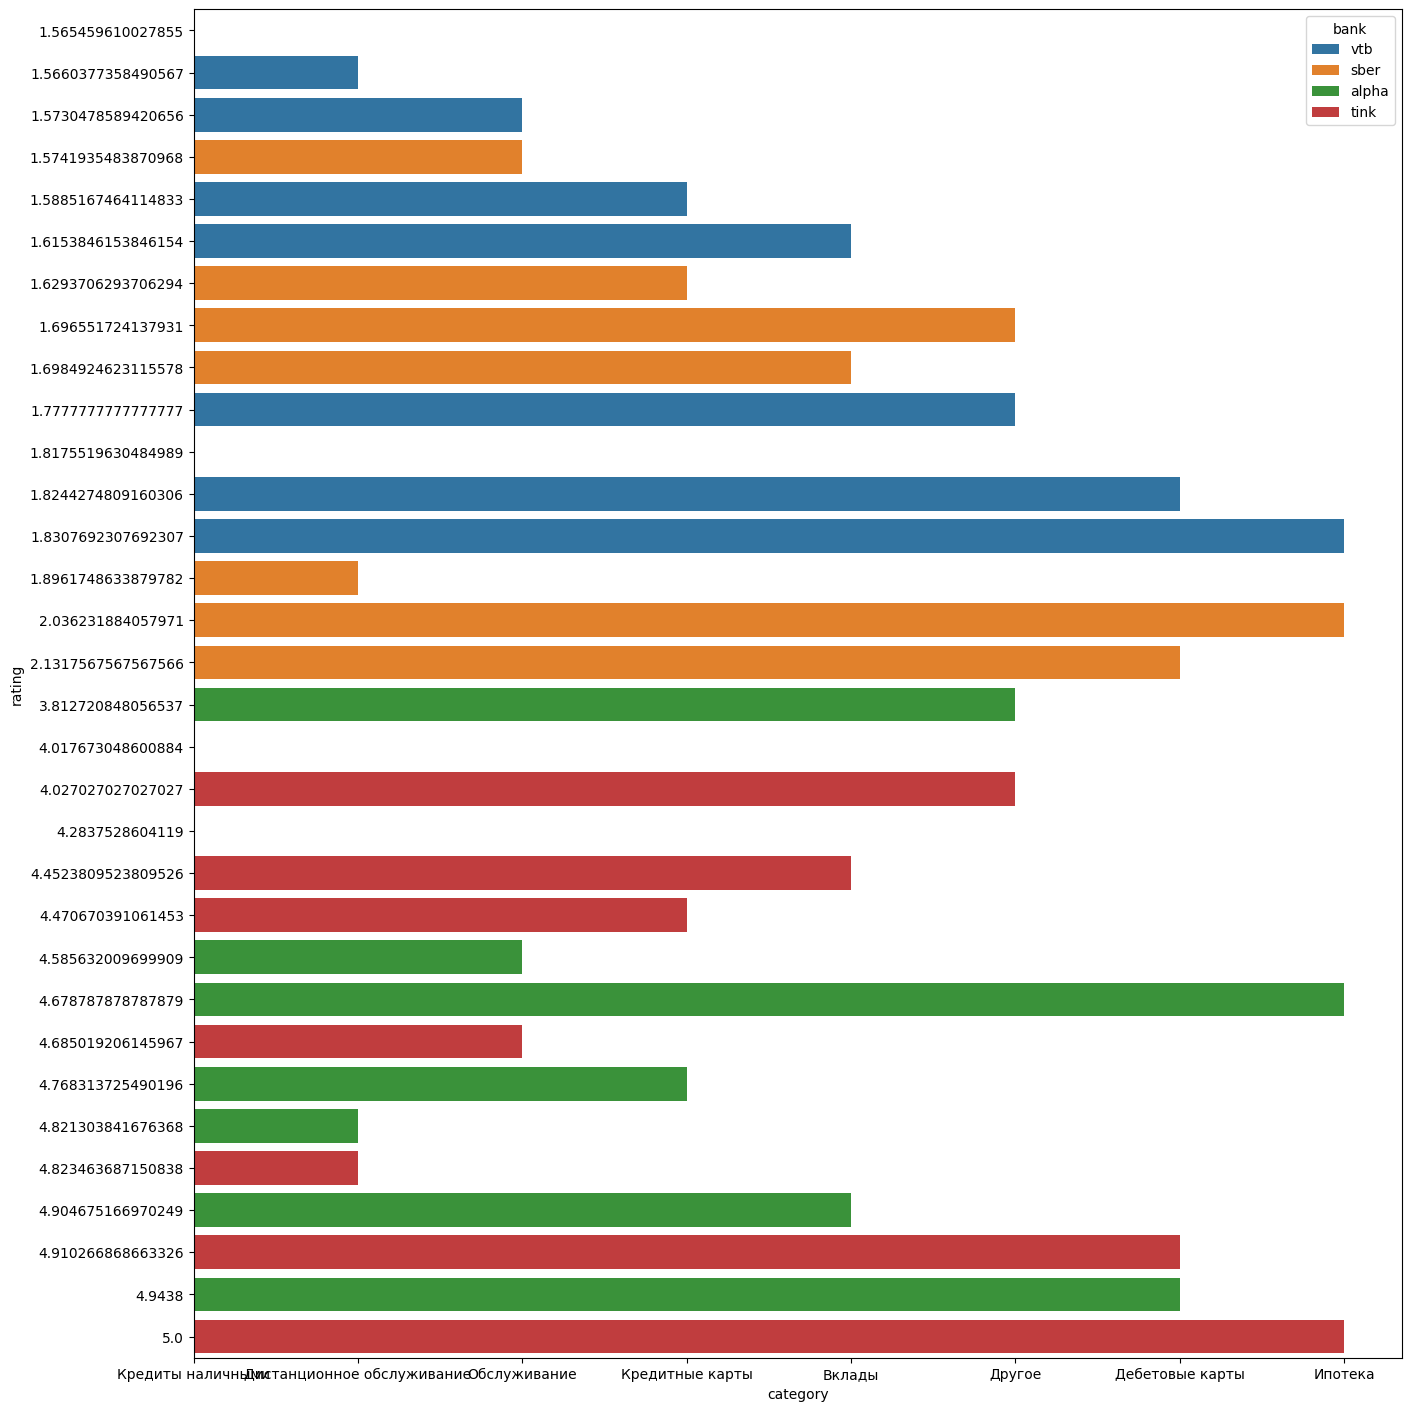

In [153]:
fig, ax = plt.subplots(layout="constrained", figsize=(14, 14))
sns.barplot(mean_ratings, x='category', hue='bank', y='rating', ax=ax, orient='h')

In [ ]:
fig, ax = plt.subplots(layout="constrained")

mean_ratings

sns.barplot(y=result.index, x=result.values, orient='h')
# plt.xticks(fontsize=10, rotation=45)
ax.set_ylabel("Категория")
ax.set_xlabel("Средняя оценка")
ax.bar_label(ax.containers[0], fmt=lambda x: str(round(x, 2)), label_type='center')

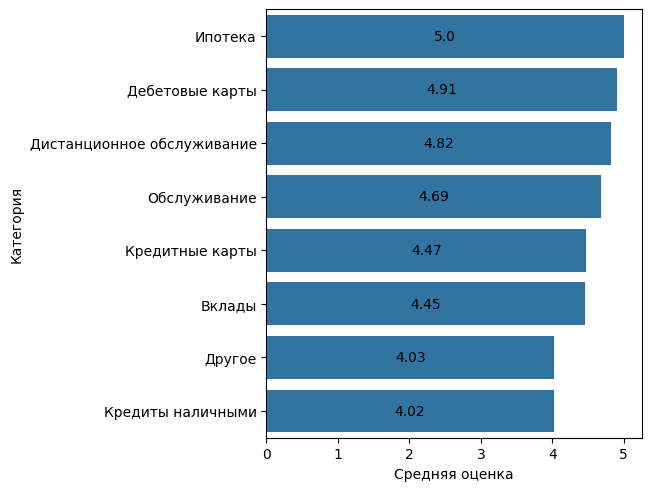

In [122]:
def plot_mean_ratings(data, data_competitors):
    fig, ax = plt.subplots(layout="constrained")
    result = (
        data
        .groupby("category")['rating']
        .agg('mean')
        .sort_values(ascending=False)
    )
    sns.barplot(y=result.index, x=result.values, orient='h')
    # plt.xticks(fontsize=10, rotation=45)
    ax.set_ylabel("Категория")
    ax.set_xlabel("Средняя оценка")
    ax.bar_label(ax.containers[0], fmt=lambda x: str(round(x, 2)), label_type='center')
    # st.pyplot(fig)

# st.subheader("Средняя оценка по категории")
plot_mean_ratings(df, df_competitors)

In [109]:
def mapper_input_ids(tokenizer, text):
  words = text.split(" ")
  result = defaultdict(int)
  input_ids = []
  current = 1
  for i, word in enumerate(words):
    word_input = tokenizer.encode(word, add_special_tokens=False)
#     print(i, word, word_input)
    input_ids.extend(word_input)

    result[i] = (current, current + len(word_input))
    current += len(word_input)
  return input_ids, result

class BertContextTokenizer(Dataset):

  def __init__(self, data, tokenizer, pos_column="aspect_ix", text_column="text", target_column="target", context_size=100):
    super().__init__()
    self.ixs = data[pos_column]
    self.text = data[text_column]
    self.y = data[target_column]
    self.context_size = context_size
    self.tokenizer = tokenizer

  def __getitem__(self, x):

    input = [self.tokenizer.encode(".")[0]]
    text = self.text[x]
    y = self.y[x]
    at_old_start = text.split(" ")[self.ixs.iloc[x][0]]
    at_old_end = text.split(" ")[self.ixs.iloc[x][-1]]
    at_ix_start = text.index(at_old_start); at_ix_end = text.index(at_old_end) + len(at_old_end)
    left_part = text[:at_ix_start]; aspect = text[at_ix_start:at_ix_end]; right_part = text[at_ix_end:]
    text = left_part + "<ASPECT> " + aspect + " <ASPECT>" + right_part
    ids, mapper_ids  = mapper_input_ids(self.tokenizer, text)
#     print(mapper_ids)
    left_at = mapper_ids[self.ixs.iloc[x][0] + 1][0] #прибавляем 1, т.к слово аспект появилось спереди
    right_at = mapper_ids[self.ixs.iloc[x][-1] + 1][-1]
    left_gl = max(0, left_at - self.context_size)
    right_gl = min(len(ids) - 1, right_at + self.context_size)
#     print(left_at, right_at, left_gl, right_gl, ids)
    input.extend(ids[left_gl:(right_gl + 1)])
    input.extend([self.tokenizer.encode(".")[-1]])
    
    print(self.tokenizer.decode(input))
    return input, y

  def __len__(self):
    return len(self.text)

In [110]:
class BertClassifierModel(nn.Module):
    def __init__(self, hidden_dim, bert_model, n_classes):
        super().__init__()
        self.bert = bert_model
        self.linear = nn.Sequential(OrderedDict([
            ("ln1", nn.Linear(768, hidden_dim)),
            ("act", nn.ReLU()),
            ("ln2", nn.Linear(hidden_dim, n_classes))
        ]))
        # self.linear = nn.Linear(768, n_classes)

    def forward(self, input_ids, attention_mask):
      x = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
      x = self.linear(x)
      return x

In [111]:
def infer_model(text, ixs, path_to_model):
    id2label = {0: 'Обслуживание',
         1: 'Банковские условия',
         2: 'Общее впечатление о банке',
         3: 'Функционал',
         4: 'Интерфейс',
         5: 'Конкуренты',
         6: 'Другое',}
    df_dict = {
        "text": [text],
        "aspect_ix" : [ixs],
        "cat" : [1]
    }
    tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
    model = BertClassifierModel(bert_model=AutoModel.from_pretrained("DeepPavlov/rubert-base-cased"), hidden_dim=256, n_classes=7)
    model.load_state_dict(torch.load(path_to_model, map_location="cpu"))
    df = pd.DataFrame.from_dict(df_dict)
    ds = BertContextTokenizer(df, tokenizer=tokenizer, target_column="cat", context_size=10)
    logits = model(input_ids=torch.tensor(ds[0][0]).view(1, -1), attention_mask=torch.tensor([1] * len(ds[0][0])).view(1, -1))
    result = torch.argmax(torch.nn.functional.softmax(logits.cpu(), dim=1))
    return id2label[result.item()]
print(infer_model("кредитные ставки высокие", [0, 1], "checkpoint/model_f1_0.769.pt"))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mo

[CLS] < ASPECT > кредитные ставки < ASPECT > высокие [SEP]
[CLS] < ASPECT > кредитные ставки < ASPECT > высокие [SEP]
Банковские условия


In [112]:
infer_model("В данном банке очень грубые сотрудники", [5], "checkpoint/model_f1_0.769.pt")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mo

[CLS] данном банке очень грубые < ASPECT > сотрудники < ASPECT > [SEP]
[CLS] данном банке очень грубые < ASPECT > сотрудники < ASPECT > [SEP]


'Обслуживание'

In [113]:
infer_model("Тинькофф самый лучший", [0], "checkpoint/model_f1_0.769.pt")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mo

[CLS] < ASPECT > Тинькофф < ASPECT > самый лучший [SEP]
[CLS] < ASPECT > Тинькофф < ASPECT > самый лучший [SEP]


'Обслуживание'

In [104]:
infer_model("Сбер намного лучше этого банка", [0], "checkpoint/model_f1_0.769.pt")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mo

'Общее впечатление о банке'

In [17]:
pip install python-Levenshtein

  Obtaining dependency information for python-Levenshtein from https://files.pythonhosted.org/packages/72/8e/559c539e76bc0b1defec3da39a047fe151258efc9b215bf41db41e2c7922/python_Levenshtein-0.25.1-py3-none-any.whl.metadata
  Obtaining dependency information for Levenshtein==0.25.1 from https://files.pythonhosted.org/packages/8b/e3/0e928f0b75e7b6e28c325a72442291ee6b60687cf42a5045fd35ce115605/Levenshtein-0.25.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for rapidfuzz<4.0.0,>=3.8.0 from https://files.pythonhosted.org/packages/bf/84/a3e07222e3f48703232474844b3d0ab16ddd6a0c35af0ced7ce239820c22/rapidfuzz-3.9.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.6/103.6 kB 709.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [30]:
from aux_functions import *

bank = 'tink'

df = pd.read_parquet(f'data/results_sravni_{bank}.parquet')
df['category'] = df['category'].map(map_category)
df['triplets'] = df['pred_text']
df['timestamp'] = pd.to_datetime(df['time'].apply(lambda x: x[:10]))
df = df[~df['text'].apply(lambda x: 'ЛовиОтзыв' in x)]

count_dates = df['time'].value_counts()
# count_dates[count_dates<100]
df = df[df['time'].isin(count_dates[count_dates<100].index)]
# st.write(df)
# df


# data['triplet'] = data['pred_text'].apply(lambda x: eval(x))
# all_triplets = []
# for label in data['triplet']:
#     all_triplets.extend(label)
# st.write(data)

all_triplets = []
all_times = []
for _, (label, time) in df[['triplets', 'timestamp']].iterrows():
    # all_triplets.extend(eval(label))
    label = eval(label)
    all_triplets.extend(label)
    all_times += [time] * len(label)

data = []
for (triplet, time) in zip(all_triplets, all_times):
    # st.write(triplet)
    # st.write(triplet)
    at, ot, sp = triplet
    at = lemmatize(at.lower())
    ot = lemmatize(ot.lower())

    data.append([at, ot, sp, (at, ot, sp), (at, ot), time])
data = pd.DataFrame(data)
data.columns = ['aspect', 'opinion', 'sentiment', 'triplet', 'aspect_opinion', 'timestamp']
data = data[~data.aspect.apply(is_stop_word)]
data

,aspect,opinion,sentiment,triplet,aspect_opinion,timestamp
0,уровень,высокий,POS,"(уровень, высокий, POS)","(уровень, высокий)",2024-03-20
1,подход,индивидуальный,POS,"(подход, индивидуальный, POS)","(подход, индивидуальный)",2024-03-20
2,менеджер,поблагодарить,POS,"(менеджер, поблагодарить, POS)","(менеджер, поблагодарить)",2024-03-20
4,работа,отличный,POS,"(работа, отличный, POS)","(работа, отличный)",2016-08-29
6,работа,отличный,POS,"(работа, отличный, POS)","(работа, отличный)",2016-08-29
...,...,...,...,...,...,...
33266,условие,хороший,POS,"(условие, хороший, POS)","(условие, хороший)",2019-12-10
33267,оформление,удобный,POS,"(оформление, удобный, POS)","(оформление, удобный)",2019-12-10
33268,оформление,быстрый,POS,"(оформление, быстрый, POS)","(оформление, быстрый)",2019-12-10
33269,услуга,удобный,POS,"(услуга, удобный, POS)","(услуга, удобный)",2019-12-10


In [63]:
aspect_counts = data['aspect'].value_counts()
correct_aspects = {}
for i, (a, count) in enumerate(aspect_counts.items()):
    if len(a) < 6: continue
    for j in range(i):
        b = aspect_counts.index[j]
        if a[0] == b[0] and a[-1] == b[-1] and lev(a, b) <= 1:
            correct_aspects[a] = b
            break

In [64]:
correct_aspects

{'кэшбек': 'кэшбэк',
 'кешбек': 'кэшбек',
 'кешбэк': 'кэшбэк',
 'кеш бек': 'кешбек',
 'кардхолдер': 'картхолдер',
 'кэш бэк': 'кэшбэк',
 'привилегия': 'привелегия',
 'тинькоф': 'тинькофф',
 'интерфэйс': 'интерфейс',
 'потдержка': 'поддержка',
 'кежбек': 'кешбек',
 'кешбэкома': 'кэшбэкома',
 'прилодение': 'приложение',
 'здание': 'знание',
 'персоонал': 'персонал',
 'обслужевание': 'обслуживание',
 'видение': 'ведение',
 'прддержка': 'поддержка',
 'констультация': 'консультация',
 'облуживание': 'обслуживание',
 'транзация': 'транзакция',
 'обсуживание': 'обслуживание',
 'приимущество': 'преимущество',
 'спектор': 'спектр',
 'кеш бэк': 'кешбэк',
 'партнëр': 'партнёр',
 'клиентоориентированость': 'клиентоориентированность',
 'помошник': 'помощник',
 'кашбэк': 'кэшбэк',
 'ньюанс': 'нюанс',
 'концеапция': 'концепция',
 'проффессионализм': 'профессионализм',
 'кенбэк': 'кешбэк',
 'содрудник': 'сотрудник',
 'кашбек': 'кэшбек',
 'впечателение': 'впечатление',
 'иниерфейс': 'интерфейс',
 'оьсл

In [48]:
aspect_counts.loc['кэшбэк'], aspect_counts.loc['кешбэк']

(645, 141)

In [50]:
correct_aspects

{'кешбэк': 'кешбек'}

In [40]:
a

'кешбэк'

In [18]:
from Levenshtein import distance as lev

In [24]:
lev('кэшбэк', 'кешбек')

2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [15]:
df = pd.read_parquet('data/results_sravni_vtb.parquet')
df

,text,pred,pred_text,time,rating,old_text,category
0,Пользуюсь сервисом Private уже около года . До...,"[([67], [66], 'POS'), ([40], [39], 'POS'), ([5...","[('уровень', 'высокий', 'POS'), ('подход', 'ин...",2024-03-20T13:32:26.076317Z,5,Пользуюсь сервисом Private уже около года. До ...,serviceLevel
1,Пока полёт нормлаьный . Заказал кредит наличны...,"[([40], [44], 'POS'), ([40], [42], 'POS'), ([1...","[('договор', 'понятный', 'POS'), ('договор', '...",2023-12-15T21:45:04.176968Z,5,Пока полёт нормлаьный.\n\nЗаказал кредит налич...,credits
2,Хочу поблагодарить Тинькофф Банк за удивительн...,"[([277], [276], 'POS'), ([277], [280], 'POS'),...","[('Банк', 'умный', 'POS'), ('Банк', 'равнодушн...",2023-10-27T19:25:57.06378Z,5,Хочу поблагодарить Тинькофф Банк за удивительн...,credits
3,"Позвонил , уточнил , одобрили , приехали , под...",[],[],2023-08-24T19:33:08.249014Z,5,"Позвонил, уточнил, одобрили, приехали, подписа...",credits
4,"Брала кредит на ремонт , срочно нужно было . В...","[([51], [48], 'POS'), ([19], [18], 'POS')]","[('условия', 'удобные', 'POS'), ('отзывов', 'х...",2023-08-06T11:08:08.167725Z,5,"Брала кредит на ремонт, срочно нужно было. Выб...",credits
...,...,...,...,...,...,...,...
2574,С 1 апреля 2019 ВТБ ввел оплату SMS оповещений...,"[([255], [254], 'NEG')]","[('картину', 'печальную', 'NEG')]",2019-04-18T01:55:57.773Z,2,С 1 апреля 2019 ВТБ ввел оплату SMS оповещений...,other
2575,28.01.2019 г . оформила кредит в банке ВТБ гор...,[],[],2019-03-03T20:58:40.497Z,1,28.01.2019 г.оформила кредит в банке ВТБ гор.А...,other
2576,"10.12.18г по адресу г . Обнинск , ул . Аксёнов...",[],[],2018-12-12T21:26:55.707Z,2,"10.12.18г по адресу г. Обнинск, ул. Аксёнова д...",other
2577,26 июля был наложен арест на зп карту банка вт...,[],[],2018-10-15T13:47:56.8Z,3,26 июля был наложен арест на зп карту банка вт...,other


In [16]:
df['rating'].mean()

1.6400613967766693

In [137]:
df = pd.read_parquet('data/results_sravni_tink.parquet')
df['category'] = df['category'].map(map_category)
df['time'] = pd.to_datetime(df['time'].apply(lambda x: x[:10]))
df = df[~df['text'].apply(lambda x: 'ЛовиОтзыв' in x)]

count_dates = df['time'].value_counts()
# count_dates[count_dates<100]
df = df[df['time'].isin(count_dates[count_dates<100].index)]
df

,text,pred,pred_text,time,rating,old_text,category
0,Оформил карточку Тинькофф еще лет 8 - 10 лет н...,"[([362], [365, 366], 'NEG')]","[('сервис', 'не работает', 'NEG')]",2024-03-18,1,Оформил карточку Тинькофф еще лет 8-10 лет наз...,Обслуживание
1,По ошибке банка также сменили мне тариф в Тинь...,"[([106], [117], 'NEG')]","[('представитель', 'обманул', 'NEG')]",2024-03-13,1,По ошибке банка также сменили мне тариф в Тинь...,Обслуживание
2,Навязали кредитную карту в аэропорту кредитную...,"[([2], [0], 'NEG')]","[('карту', 'Навязали', 'NEG')]",2024-03-10,1,Навязали кредитную карту в аэропорту кредитную...,Обслуживание
3,К сожалению приходится прощаться с Тинькоф бан...,[],[],2024-02-14,1,К сожалению приходится прощаться с Тинькоф бан...,Обслуживание
4,I use the loyalty system from Tinkoff in every...,[],[],2024-02-09,1,I use the loyalty system from Tinkoff in every...,Обслуживание
...,...,...,...,...,...,...,...
19862,"Открывала ИП , обратилась в Тинькофбанк , так ...",[],[],2021-07-31,1,"Открывала ИП, обратилась в Тинькофбанк, так ка...",Другое
19863,"Я не являюсь клиентом банка , но пришлось с ни...","[([133], [134, 135, 136], 'NEG'), ([153], [154...","[('ситуация', 'никак не решается', 'NEG'), ('п...",2021-03-17,1,"Я не являюсь клиентом банка, но пришлось с ни ...",Другое
19864,10.03.20 купила билеты в Вильнюс на 20 марта ....,[],[],2020-03-27,3,10.03.20 купила билеты в Вильнюс на 20 марта. ...,Другое
19865,"Сами банковские услуги удобные , и оформление ...","[([99], [98], 'POS'), ([99], [95], 'POS'), ([8...","[('отношение', 'лояльное', 'POS'), ('отношение...",2019-12-10,4,"Сами банковские услуги удобные, и оформление б...",Другое


In [9]:
pd.read_parquet('data/results_sravni_sber.parquet')['time'].max()

'2024-03-21T11:07:21.173756Z'

In [138]:
# count_dates[count_dates<100]

In [139]:
map_category = {
                'debitCards': 'Дебетовые карты',
                'creditCards': 'Кредитные карты',
                'remoteService': 'Дистанционное обслуживание',
                'serviceLevel': 'Обслуживание',
                'credits': 'Кредиты наличными',
                'savings': 'Вклады',
                'mortgage': 'Ипотека',
                'other': 'Другое'
               }

In [118]:
# df[df.time==pd.to_datetime('2021-10-07')]['text'].values[2:]

In [128]:
# df['time'].value_counts().to_dict()#.sort_index()

In [130]:
# df[df.time == pd.to_datetime('2022-03-17')]['text'].values[5:]

In [120]:
# smoothing_k = 2
# data_ratio = counted_sentiment[["timestamp"]].iloc[::smoothing_k]
# data_ratio["Доля положительных"] = ratio[::smoothing_k]

# fig = px.line(data_ratio, x="timestamp", y="Доля положительных")
# fig.update_yaxes(range=[min(ratio) - 1, max(ratio) + 1], autorange=False)
# #   fig.get_axes().set_ylim(min(ratio)-1, max(ratio)+1)
# # fig.update_layout(scattermode="group")
# #   fig.yaxis_title('Доля положительных триплетов')
# #   fig.xaxis_title('Дата')
# fig.update_layout(
#     title=f"Доля положительных триплетов по времени",
#     xaxis_title="Дата",
#     yaxis_title="Доля положительных триплетов",
# )
# # fig.show()
# st.plotly_chart(fig)

In [140]:
df['time'].value_counts()

time
2021-10-04    94
2022-11-17    93
2022-11-06    90
2022-03-13    88
2022-03-18    82
              ..
2015-08-28     1
2015-08-07     1
2015-08-06     1
2015-07-29     1
2019-10-09     1
Name: count, Length: 1577, dtype: int64

/Users/nik/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



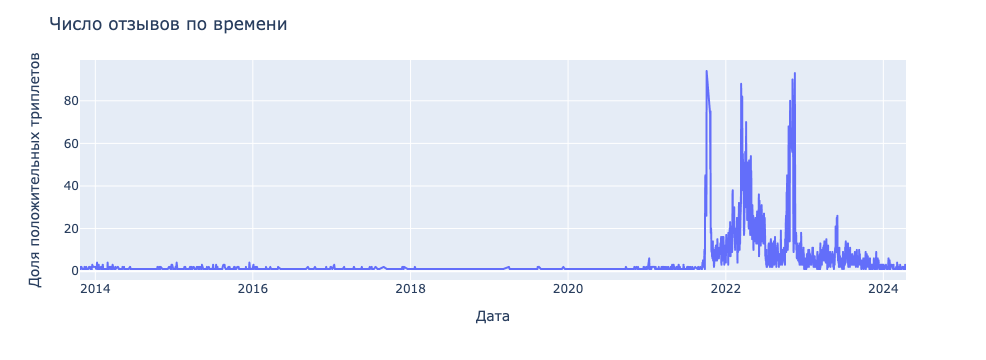

In [141]:
# weeks = df['time'].astype(int) / 10 ** 9 / 3600 / 24 // 30
fig = px.line(x=df['time'].value_counts().sort_index().index, y=df['time'].value_counts().sort_index().values)
# fig.update_yaxes(range=[min(ratio) - 1, max(ratio) + 1], autorange=False)

#   fig.get_axes().set_ylim(min(ratio)-1, max(ratio)+1)
# fig.update_layout(scattermode="group")
#   fig.yaxis_title('Доля положительных триплетов')
#   fig.xaxis_title('Дата')
fig.update_layout(
    title=f"Число отзывов по времени",
    xaxis_title="Дата",
    yaxis_title="Доля положительных триплетов",
)
# fig.show()
fig

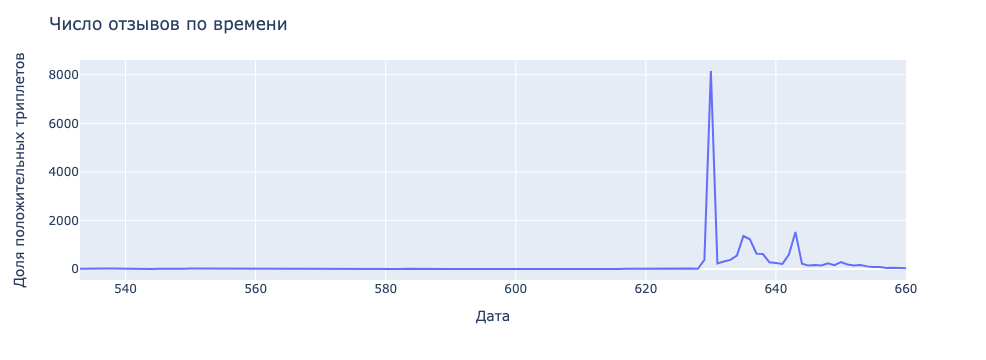

In [86]:
weeks = df['time'].astype(int) / 10 ** 9 / 3600 / 24 // 30
fig = px.line(x=weeks.value_counts().sort_index().index, y=weeks.value_counts().sort_index().values)
# fig.update_yaxes(range=[min(ratio) - 1, max(ratio) + 1], autorange=False)

#   fig.get_axes().set_ylim(min(ratio)-1, max(ratio)+1)
# fig.update_layout(scattermode="group")
#   fig.yaxis_title('Доля положительных триплетов')
#   fig.xaxis_title('Дата')
fig.update_layout(
    title=f"Число отзывов по времени",
    xaxis_title="Дата",
    yaxis_title="Доля положительных триплетов",
)
# fig.show()
fig

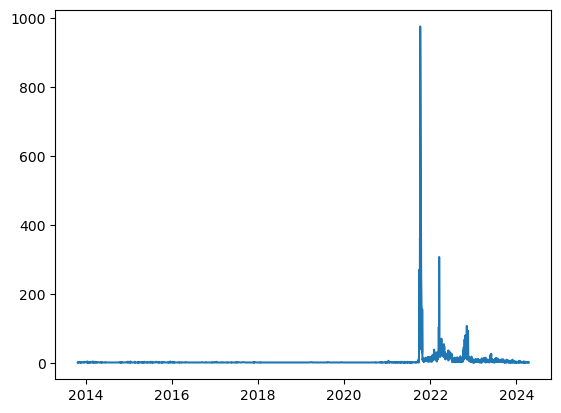

In [65]:
plt.plot(df['time'].value_counts().sort_index())

In [142]:
res = pd.read_parquet('data/alpha.parquet')
res

,triplets,timestamp
0,[],2024-04-19 07:04:00
1,[],2024-04-17 17:04:00
2,"[('сотрудников', 'спасибо', 'POS')]",2024-04-17 05:01:00
3,[],2024-04-16 19:02:00
4,"[('обслуживанием', 'внимательным', 'POS'), ('о...",2024-04-15 20:05:00
...,...,...
27113,"[('обслуживание', 'Ужасное', 'NEG')]",2018-11-30 09:01:00
27114,[],2018-11-03 10:00:00
27115,"[('отношение', 'безобразное', 'NEG')]",2018-10-10 18:00:00
27116,"[('менеджер', 'молодчинка', 'POS'), ('девушка'...",2018-06-18 15:05:00


In [150]:
c = 0
for l in res['triplets']:
    # print(len(eval(l)))
    c += len(eval(l))
c

55750

In [4]:
len(pd.read_parquet('data/results_sravni_alpha.parquet')) + \
len(pd.read_parquet('data/results_sravni_sber_cats.parquet')) + \
len(pd.read_parquet('data/results_sravni_tink.parquet')) + \
len(pd.read_parquet('data/results_sravni_vtb.parquet'))

53191

In [7]:
pd.read_parquet('data/results_sravni_alpha.parquet').columns

Index(['text', 'pred', 'pred_text', 'time', 'rating', 'old_text', 'category'], dtype='object')

In [5]:
pd.read_csv('aaa')

,Unnamed: 0,text,pred,label,pred_text,label_text,time,rating,old_text,category
0,0,Оформил карточку Тинькофф еще лет 8 - 10 лет н...,"[([362], [365, 366], 'NEG')]",[],"[('сервис', 'не работает', 'NEG')]",[],2024-03-18T06:57:04.493153Z,1,Оформил карточку Тинькофф еще лет 8-10 лет наз...,serviceLevel
1,1,Оформил карточку Тинькофф еще лет 8 - 10 лет н...,"[([362], [365, 366], 'NEG')]",[],"[('сервис', 'не работает', 'NEG')]",[],2024-03-18T06:57:04.493153Z,1,Оформил карточку Тинькофф еще лет 8-10 лет наз...,mortgage
2,2,Быстро и без лишних вопросов оформил кредит на...,[],[],[],[],2023-12-08T13:26:29.931209Z,5,Быстро и без лишних вопросов оформил кредит на...,credits
3,3,"Здравствуйте , мне несомненно понравилась кред...","[([6], [4], 'POS')]",[],"[('карта', 'понравилась', 'POS')]",[],2024-01-27T10:46:37.581422Z,5,"Здравствуйте,мне несомненно понравилась кредит...",creditCards
4,4,Доброго времени суток ! Пару месяцев назад я ч...,[],[],[],[],2024-04-04T08:12:40.034798Z,1,Доброго времени суток!\nПару месяцев назад я ч...,debitCards
5,5,"В банке есть акция , по которой в случае , есл...",[],[],[],[],2022-11-25T19:29:24.909327Z,5,"В банке есть акция, по которой в случае, если ...",savings
6,6,Спасибо за услуги банка . Отдельное хочу побла...,"[([8], [7], 'POS')]",[],"[('сотруднику', 'поблагодарить', 'POS')]",[],2024-04-15T11:07:49.229942Z,5,Спасибо за услуги банка. Отдельное хочу поблаг...,remoteService
7,7,"Доброго времени суток , решил перевести свою с...","[([516], [515], 'NEG'), ([492], [494], 'NEG'),...",[],"[('оператором', 'отвратительным', 'NEG'), ('си...",[],2023-10-24T09:22:48.163765Z,1,"Доброго времени суток, решил перевести свою се...",other


In [50]:
mean_rating = df[['rating', 'category']].groupby('category')['rating'].agg('mean')
mean_rating

category
Вклады                        4.495614
Дебетовые карты               4.917600
Дистанционное обслуживание    4.831772
Другое                        4.168831
Кредитные карты               4.522784
Кредиты наличными             4.057665
Обслуживание                  4.714121
Name: rating, dtype: float64

<Axes: xlabel='category'>

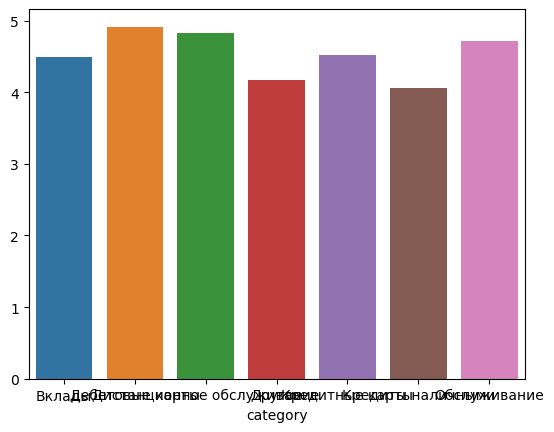

In [51]:
import seaborn as sns
sns.barplot(x=mean_rating.index, y=mean_rating.values)

In [31]:
df['category'].value_counts()

category
debitCards       10000
serviceLevel      3477
remoteService     2883
creditCards       2414
credits            711
savings            228
other              154
Name: count, dtype: int64

In [25]:
import pandas as pd
import re

In [24]:
train = pd.read_csv('/Users/nik/Downloads/train_Feedback/train_data.csv')
train['object'].value_counts()

object
0    38
2    35
1    30
Name: count, dtype: int64

,text,pred,pred_text,time,rating,old_text
0,Менеджер Ирина ( внутренний номер 6907919 . ) ...,"[([0], [8], 'POS')]","[('Менеджер', 'Вежливая', 'POS')]",2022-02-09T13:47:46.851709Z,5,Менеджер Ирина (внутренний номер 6907919.) Веж...
1,Опыт с Тинькофф - это мой первый опыт с банкам...,[],[],2022-02-09T13:01:48.956559Z,5,Опыт с Тинькофф - это мой первый опыт с банкам...
2,Оплатила на Кубе экскурсию дебетовой картой Ти...,"[([75], [73, 74], 'POS'), ([75], [74], 'POS')]","[('банк', 'Самый лучший', 'POS'), ('банк', 'лу...",2022-02-09T12:59:35.196095Z,5,Оплатила на Кубе экскурсию дебетовой картой Ти...
3,Клиент банка уже 2 года очень быстрое обслужив...,"[([7], [6], 'POS')]","[('обслуживание', 'быстрое', 'POS')]",2022-02-09T12:33:08.102916Z,5,Клиент банка уже 2 года очень быстрое обслужив...
4,Работаем с банком уже 8 месяцев . За это время...,"[([14], [13], 'POS'), ([150], [149], 'POS')]","[('отношения', 'хорошие', 'POS'), ('человечек'...",2022-02-09T11:49:07.328451Z,5,Работаем с банком уже 8 месяцев. За это время ...
...,...,...,...,...,...,...
24808,"Самый прогрессивный банк , с которым я взаимод...","[([2], [1], 'POS'), ([2], [0, 1], 'POS'), ([19...","[('банк', 'прогрессивный', 'POS'), ('банк', 'С...",2022-02-09T15:19:21.695843Z,5,"Самый прогрессивный банк, с которым я взаимоде..."
24809,Благодарность за понимание ! Андрей спасибо бо...,[],[],2022-02-09T14:35:23.682053Z,5,Благодарность за понимание!Андрей спасибо боль...
24810,Около года уже являюсь клиентом Тинькофф Банка...,"[([226], [225], 'POS'), ([89], [91], 'POS')]","[('предложение', 'лучшее', 'POS'), ('результат...",2022-02-09T14:04:10.518413Z,5,Около года уже являюсь клиентом Тинькофф Банка...
24811,"Мне нравится манера общенияв чатах с банком , ...",[],[],2022-02-09T14:02:04.007323Z,5,"Мне нравится манера общенияв чатах с банком, с..."


In [9]:
new_data = ['ОПАСНОСТЬ!!!! БУДЪТЕ ОСТОРОЖНЫ!!! Купили ребенку курс в этой шараге. При оформлении договора от нас был прямой вопрос, если захотим прекратить обучение и вернуть деньги можно ли это сделать... На что получили утвердительный ответ от менеджера( они по телефону и сейчас так говорят, что возвращают) Решили закончить обучение раньше и вернуть сумму остатка обучения, на что получили отказ! Привлекаем юристов и это так не оставим. Произвол на ровном месте, надеялся, что эти времена с обманом потребителя давно прошли, но нет! Так что встретимся в суде господа бизнесмены из 90-х!',
           'ЕСЛИ ВЫ РЕШИЛИ ОБРАТИТЬСЯ В GB ПОДУМАЙТЕ НЕ СЕМЬ РАЗ,А ЛУЧШЕ ДВАДЦАТЬ СЕМЬ. Не буду расписывать всю ситуацию в деталях, но про возврат денежных средств полная правда. Одни менеджеры по продажам говорят и присылают договора без пунктов о возврате. Другие менеджера по возвратам противоречат продажникам и называют их не компетентными сотрудниками(вас не правильно проинформировали,они этим не занимаются и не могут этого знать). Если вы доверяете свои накопления этой организации будьте готовы в случае отказа от обучения либо получить копейки от вложенной суммы, либо получить три килограмма НИЧЕГО! Я полностью поддерживаю недовольство людей которые написали отзывы с проблемой о возврате. Мы думали это дно, но снизу GB постучали... Название отзыва просто супер)))']

In [20]:
def process_punctuation_txt(review):
  # Обрабатываем знаки препинания
    review = re.sub(rf'(\W)', rf' \1 ', review[:-14])

    review = re.sub(rf'\s+', rf' ', review)

    for punct in '.,':
        review = re.sub(rf'([\d\{punct}]) (\{punct}) ([\d\{punct}])', rf'\1\2\3', review)

    for punct in '!?':
        review = re.sub(rf'(\{punct}) (\{punct}) (\{punct})', rf'\1\2\3', review)

    if review[-1] == ' ':
        review = review[:-1]

    if review[-1] not in '.!?':
        review += ' .'
    review += '#### #### ####'

    return review


def add_spaces(review):
    pattern=r'(\w\w[а-яё])([А-Я]\w\w)'
    review=re.sub(pattern, r'\1 \2', review)
    return review
    


def process_reviews(reviews):
    
    reviews = reviews.apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    reviews = reviews.apply(lambda x: x + '#### #### ####[]')
    reviews = reviews.apply(add_spaces)
    reviews = reviews.apply(process_punctuation_txt)
        
    return reviews.values.tolist()

In [21]:
process_reviews(pd.Series(new_data))

['ОПАСНОСТЬ !!! ! БУДЪТЕ ОСТОРОЖНЫ !!! Купили ребенку курс в этой шараге . При оформлении договора от нас был прямой вопрос , если захотим прекратить обучение и вернуть деньги можно ли это сделать ... На что получили утвердительный ответ от менеджера ( они по телефону и сейчас так говорят , что возвращают ) Решили закончить обучение раньше и вернуть сумму остатка обучения , на что получили отказ ! Привлекаем юристов и это так не оставим . Произвол на ровном месте , надеялся , что эти времена с обманом потребителя давно прошли , но нет ! Так что встретимся в суде господа бизнесмены из 90 - х !#### #### ####',
 'ЕСЛИ ВЫ РЕШИЛИ ОБРАТИТЬСЯ В GB ПОДУМАЙТЕ НЕ СЕМЬ РАЗ , А ЛУЧШЕ ДВАДЦАТЬ СЕМЬ . Не буду расписывать всю ситуацию в деталях , но про возврат денежных средств полная правда . Одни менеджеры по продажам говорят и присылают договора без пунктов о возврате . Другие менеджера по возвратам противоречат продажникам и называют их не компетентными сотрудниками ( вас не правильно проинформир

In [3]:
!unzip -o data/banki_data_0_3 -d data

import os
os.replace('data/banki/train.txt', 'data/banki/train_triplets.txt')
os.replace('data/banki/dev.txt', 'data/banki/dev_triplets.txt')
os.replace('data/banki/test.txt', 'data/banki/test_triplets.txt')

for part in ['train', 'dev', 'test']:
  with open(f'data/banki/{part}_triplets.txt') as f:
    lines = f.readlines()

  lines = ['####'.join(line.split('#### #### ####')) for line in lines]

  for i, line in enumerate(lines):
      labels = eval(line.split('####')[-1][:-1])
      for j, label in enumerate(labels):
          sentiment = label[2]
          if sentiment == 'NEU':
              label = (label[0], label[1], 'NEG')

          labels[j] = label


    #   lines[i] = line.rsplit('####', 1)[0] + '####' + '[]' + '\n'
      lines[i] = line.rsplit('####', 1)[0] + '####' + str(labels) + '\n'
    #   all_labels.append(labels)



#   lines = lines[:50]


  # lines = [line for line in lines if len(line)>3500]

#   new_lines = []
#   for line in lines:
#     labels = eval(line.split('####')[-1][:-1])
#     for (at, ot, sp) in labels:
#       if at[-1] > 512 or ot[-1] > 512:
#         new_lines.append(line)
#         break
#   lines = new_lines

  # lines = [line for line in lines if len(line)<500]#[:5]
  # lines = [line for line in lines if len(line)<750]#[:5]



#   lines = lines[:10]



  with open(f'data/banki/{part}_triplets.txt', 'w') as f:
    f.write(''.join(lines))
  print(len(lines))


  # lines = [line for line in lines if len(line)>3500]

  # new_lines = []
  # for line in lines:
  #   labels = eval(line.split('####')[-1][:-1])
  #   for (at, ot, sp) in labels:
  #     if at[-1] > 512 or ot[-1] > 512:
  #       new_lines.append(line)
  # lines = new_lines

  # lines = [line for line in lines if len(line)<500]#[:5]
  # lines = [line for line in lines if len(line)<750]#[:5]

!mkdir checkpoint

Archive:  data/banki_data_0_3.zip
   creating: data/banki/
  inflating: data/banki/test_full_short.txt  
  inflating: data/banki/test_full_long.txt  
  inflating: data/banki/dev.txt      
  inflating: data/banki/test_short_with_labels.txt  
  inflating: data/banki/test.txt     
  inflating: data/banki/train.txt    
1958
491
817


In [14]:
!python test.py \
  --bert_model ai-forever/ruBert-base \
  --model_path model_58.pt \
  --test_path data/banki/test_triplets.txt \
  --type test \
  --verbose False

/Users/nik/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
using device:cpu
Building SPAN-ASTE model...
817it [05:05,  2.67it/s]
{'precision': 0.6124426313105559, 'recall': 0.5521839080459771, 'f1': 0.5807543520309478}


In [15]:
# import pickle
# with open('checkpoint/args.pkl', 'rb') as f:
#             args = pickle.load(f)
# args

In [16]:
class args:
    a = 1
    b = 2

In [17]:
args.a

1

In [19]:
args.a = {1:100}[args.a]
args.a

KeyError: 100

In [20]:
from trash import a

In [21]:
a(5)

25

In [52]:
def get_preds(dataset='banki', bert_model='banki', model_path="ai-forever/ruBert-base", test_path="data/banki/test_triplets.txt", 
              max_seq_length=512, type='test', verbose='False', use_additional_head='False', 
              use_neutral_class='False', span_maximum_length=5, load_args='True'):
    
    # args = init_args()
    # st.write(dataset)
    args = dict()
    args['dataset'] = dataset
    args['bert_model'] = bert_model
    args['model_path'] = model_path
    args['test_path'] = test_path
    args['max_seq_length'] = max_seq_length
    args['type'] = type
    args['verbose'] = verbose
    args['use_additional_head'] = use_additional_head
    args['use_neutral_class'] = use_neutral_class
    args['span_maximum_length'] = span_maximum_length
    args['load_args'] = load_args
    
    class AttributeDict(dict):
        def __getattr__(self, attr):
            if attr in self:
                return self[attr]
            else:
                raise AttributeError(f"'{type(self).__name__}' object has no attribute '{attr}'")

    # Example usage:
    args = AttributeDict(args)
    return args
    

In [54]:
args = get_preds()
args

{'dataset': 'banki',
 'bert_model': 'banki',
 'model_path': 'ai-forever/ruBert-base',
 'test_path': 'data/banki/test_triplets.txt',
 'max_seq_length': 512,
 'type': 'test',
 'verbose': 'False',
 'use_additional_head': 'False',
 'use_neutral_class': 'False',
 'span_maximum_length': 5,
 'load_args': 'True'}

In [55]:
args.use_additional_head = {'False': False, 'True': True}[args.use_additional_head]

In [56]:
args

{'dataset': 'banki',
 'bert_model': 'banki',
 'model_path': 'ai-forever/ruBert-base',
 'test_path': 'data/banki/test_triplets.txt',
 'max_seq_length': 512,
 'type': 'test',
 'verbose': 'False',
 'use_additional_head': 'False',
 'use_neutral_class': 'False',
 'span_maximum_length': 5,
 'load_args': 'True'}

In [29]:
dd = 1

In [31]:
dd

1

In [32]:
dataset

NameError: name 'dataset' is not defined

In [30]:
class args:
    dd = dd

In [42]:
class args:
    def __init__(self, x):
        self.x = x

In [43]:
args.x

AttributeError: type object 'args' has no attribute 'x'

In [39]:
f()

NameError: name 'x' is not defined

In [1]:
import pandas as pd

/Users/nik/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
pd.read_csv('results.csv')

,text,pred,label,pred_text,label_text
0,В ноябре 2022 списали 5000 руб за несоблюдение...,"[([50], [49], 'NEG'), ([50], [48, 49], 'NEG')]",[],"[('банк', 'гадкий', 'NEG'), ('банк', 'Самый га...",[]
1,С 01.02.2023 у дебетовой карты Альфабанка появ...,[],[],[],[]
2,С сентября 2022 года сотрудники отделения на С...,"[([56], [55], 'NEG'), ([52], [51], 'NEG')]",[],"[('сотрудников', 'некомпетентности', 'NEG'), (...",[]
3,Решила я воспользоваться предложением и оформи...,[],[],[],[]
4,Всем здравствуйте ! Совсем недавно я узнал про...,"[([19], [18], 'POS')]",[],"[('акцию', 'привлекательную', 'POS')]",[]
